In [9]:
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
train = pd.read_parquet('../data/processed/train.parquet')
test = pd.read_parquet('../data/processed/test.parquet')

scaler = joblib.load('../models/scaler.joblib')



In [3]:
X_train = train.drop('target', axis=1)
X_train = X_train.drop(columns=['date']) 
X_train = X_train.drop(columns=['season']) 
y_train = train['target']
X_test = test.drop('target', axis=1)
X_test = X_test.drop(columns=['date']) 
X_test = X_test.drop(columns=['season']) 
y_test = test['target']

In [4]:
X_test.head()

,cheese,milk,dulce_leche,eggs,porks,vegetables,cheese_revenue,milk_revenue,dulce_leche_revenue,eggs_revenue,porks_revenue,vegetables_revenue,year,month,week_year,harvest_season,month_sin,month_cos
47,-0.977778,0.310652,0.108108,-0.082192,0.166667,0.000000,660,3303,150,165,1500,70,2023,12,48,0,-2.449294e-16,1.000000e+00
48,-0.666667,0.415767,0.324324,-0.027397,0.166667,0.139860,800,3555,180,180,1500,80,2024,1,1,0,5.000000e-01,8.660254e-01
49,-0.444444,0.453308,0.108108,0.027397,0.333333,0.195804,900,3645,150,195,1800,84,2024,2,5,0,8.660254e-01,5.000000e-01
50,-0.222222,0.490849,0.432432,0.082192,0.333333,0.279720,1000,3735,195,210,1800,90,2024,3,9,1,1.000000e+00,6.123234e-17
51,-0.311111,0.528390,0.324324,0.191781,0.166667,0.419580,960,3825,180,240,1500,100,2024,4,14,1,8.660254e-01,-5.000000e-01


In [5]:
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train, y_train)
print(f"MAE Baseline: {mae(y_test, baseline.predict(X_test)):.2f}")

MAE Baseline: 0.47


In [6]:
X_train = X_train.drop(columns=['date']) if 'date' in X_train.columns else X_train

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf, X_train, y_train,
                          cv=TimeSeriesSplit(n_splits=5),
                          scoring='neg_mean_absolute_error')
print(f"RF MAE Médio: {-rf_scores.mean():.2f}")

RF MAE Médio: 0.75


In [7]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5]
}

grid = GridSearchCV(RandomForestRegressor(),
                   param_grid,
                   cv=TimeSeriesSplit(n_splits=3),
                   scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train)

print(f"Melhores parâmetros: {grid.best_params_}")

Melhores parâmetros: {'max_depth': 5, 'n_estimators': 100}


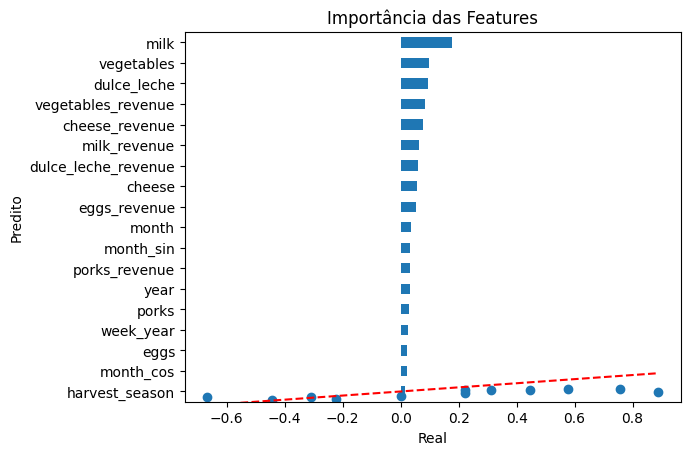

In [ ]:
# Feature Importance
pd.Series(grid.best_estimator_.feature_importances_,
          index=X_train.columns).sort_values().plot.barh()
plt.title('Importância das Features');

# Predições vs Real
plt.scatter(y_test, grid.predict(X_test))
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Real')
plt.ylabel('Predito')